In [33]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import itertools
from collections import Counter
import pandas as pd
import numpy as np
from sklearn import linear_model
import statsmodels.api as sm
import random
import matplotlib.pyplot as plt

In [35]:
random.seed(42)

In [36]:
cd /content/drive/MyDrive/master_thesis/inputs/

/content/drive/MyDrive/master_thesis/inputs


In [37]:
ls

ENCFF292FVY.tsv  ENCFF910TAZ.tsv          hg38_msxTm_ENCFF910TAZ/
ENCFF694PZC.tsv  hg38_msxTm_ENCFF292FVY/  hg38_msxTm.txt


In [38]:
final_matrix = pd.read_csv("hg38_msxTm_ENCFF910TAZ/hg38_msxTm_ENCFF910TAZ.csv")

In [39]:
def all_kmers(kmer_size):
    bases=['A','T','G','C']
    return [''.join(p) for p in itertools.product(bases, repeat=kmer_size)]

In [40]:
def count_occurance(seq_kmer_list):
    return [[x,seq_kmer_list.count(x)] for x in set(seq_kmer_list)]

In [41]:
def seq2kmer(seq, k):
    """
    Convert original sequence to kmers
    
    Arguments:
    seq -- str, original sequence.
    k -- int, kmer of length k specified.
    
    Returns:
    kmers -- str, kmers separated by space
    """
    kmer = [seq[x:x+k] for x in range(len(seq)+1-k)]
    return kmer

In [42]:
def add_kmer_count(kmers_count_df, zeros_kmers_count_df):
    for index, sets in enumerate(kmers_count_df):
        for kmer in sets:
            zeros_kmers_count_df[str(kmer[0])][index] = kmer[1]
    return zeros_kmers_count_df

In [43]:
def pipeline(final_matrix, kmer_size):
    sequences_df = final_matrix["Sequence"]
    kmers_df = sequences_df.apply(lambda x: seq2kmer(x, kmer_size))    
    kmers_count_df = kmers_df.apply(count_occurance)
    zeros_kmers_count_df = pd.DataFrame(0, index=np.arange(len(kmers_count_df)), columns=all_kmers(kmer_size))
    comp_kmers_count_df = add_kmer_count(kmers_count_df, zeros_kmers_count_df)
    comp_kmers_count_df["target"] = final_matrix["logTPM"]
    return comp_kmers_count_df

In [44]:
comp_kmers_count_df_3 = pipeline(final_matrix, 3)
comp_kmers_count_df_4 = pipeline(final_matrix, 4)
comp_kmers_count_df_5 = pipeline(final_matrix, 5)

In [45]:
from sklearn.model_selection import train_test_split

def train_val_test(comp_kmers_count_df):
    comp_kmers_count_df_train, comp_kmers_count_df_test = train_test_split(comp_kmers_count_df, test_size=0.2, random_state=42)
    comp_kmers_count_df_train, comp_kmers_count_df_val = train_test_split(comp_kmers_count_df_train, test_size=0.25, random_state=42)
    return comp_kmers_count_df_train, comp_kmers_count_df_test

In [46]:
def multireg_fit(comp_kmers_count_df):
    X = comp_kmers_count_df.iloc[:,:-1]
    Y = comp_kmers_count_df["target"]
    X = sm.add_constant(X) # adding a constant  
    model = sm.OLS(Y, X).fit()
    #print(model.summary())
    print("training R2: ", model.rsquared)
    return model

In [47]:
def multireg_prediction(model, comp_kmers_count_df):
    X = comp_kmers_count_df.iloc[:,:-1]
    X = sm.add_constant(X) # adding a constant  
    ypred = model.predict(X)
    return ypred

In [48]:
from sklearn.metrics import r2_score, mean_squared_error

def measurement_metric(true_labels, predictions, measurement):
    metric = measurement(true_labels, predictions)               
    return metric

In [49]:
def plotpredvsactual(pred, lab):
    plt.figure(figsize=(10,10))
    plt.scatter(lab, pred, c='crimson')

    p1 = max(max(pred), max(lab))
    p2 = min(min(pred), min(lab))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()

In [50]:
def multireg_model_wrapper(comp_kmers_count_df):
    comp_kmers_count_df_train, comp_kmers_count_df_test = train_val_test(comp_kmers_count_df)
    model = multireg_fit(comp_kmers_count_df_train)
    predictions = multireg_prediction(model, comp_kmers_count_df_test)
    r2 = measurement_metric(comp_kmers_count_df_test["target"], predictions, r2_score)
    print("prediction r2:" , r2)
    mse = measurement_metric(comp_kmers_count_df_test["target"], predictions, mean_squared_error)
    print("prediction mse:" , mse)
    plotpredvsactual(predictions, comp_kmers_count_df_test["target"])
    return

training R2:  0.2746455116040253
prediction r2: 0.17977800068208927
prediction mse: 5.581731638120318


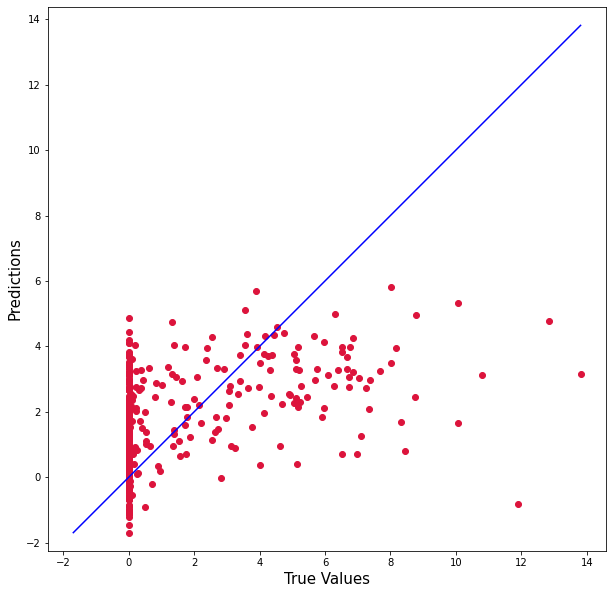

In [51]:
multireg_model_wrapper(comp_kmers_count_df_3)

training R2:  0.433272759666972
prediction r2: 0.013003343704411696
prediction mse: 6.716657767952348


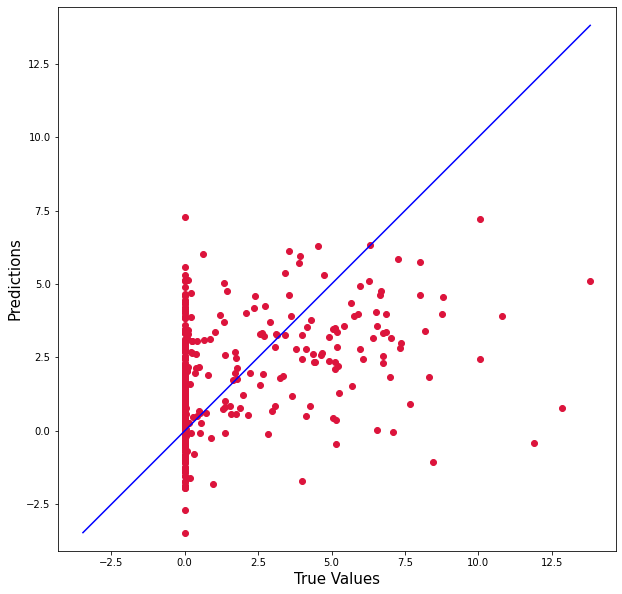

In [52]:
multireg_model_wrapper(comp_kmers_count_df_4)

training R2:  0.9161587858574589
prediction r2: -8.35948311219231
prediction mse: 63.692662531876394


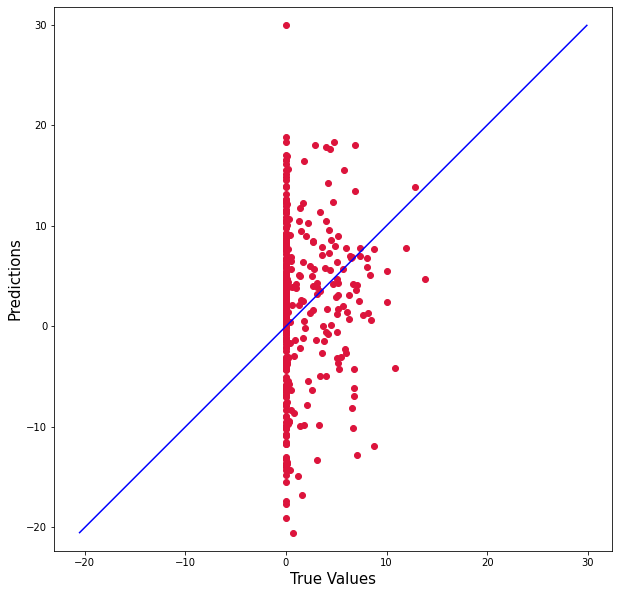

In [53]:
multireg_model_wrapper(comp_kmers_count_df_5)

training R2:  1.0
prediction r2: -0.49515803029303873
prediction mse: 10.174770840841154


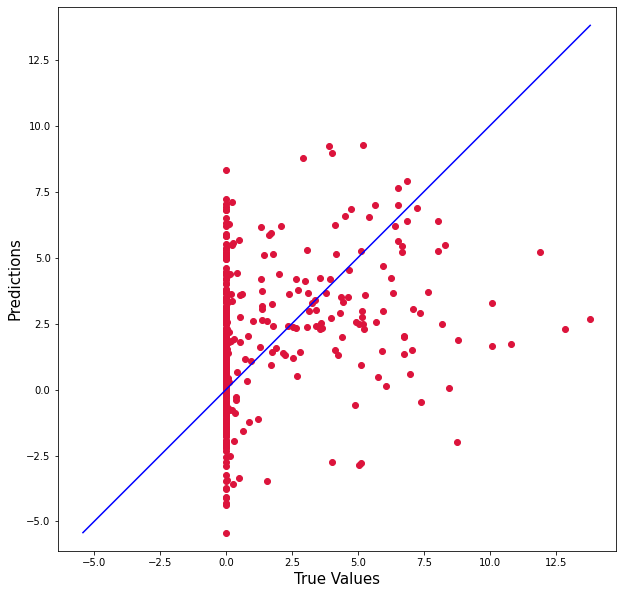

In [54]:
comp_kmers_count_df_6 = pipeline(final_matrix, 6)
multireg_model_wrapper(comp_kmers_count_df_6)